<a href="https://colab.research.google.com/github/sidddha2004/new-repo/blob/main/Copy_of_Welcome_to_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df1=pd.read_csv("/content/uav_1.csv")
df2=pd.read_csv("/content/uav_2.csv")
df3=pd.read_csv("/content/uav_3.csv")
df4=pd.read_csv("/content/uav_4.csv")
df5=pd.read_csv("/content/uav_5.csv")

df1["uav_id"]=1;
df2["uav_id"]=2;
df3["uav_id"]=3;
df4["uav_id"]=4;
df5["uav_id"]=5;

df_new = pd.concat([df1,df2,df3,df4,df5],ignore_index=True)

df_shuffled = df_new.sample(frac=1, random_state=42).reset_index(drop=True)

# Save if needed
df_shuffled.to_csv("new_combined.csv",index=False)



In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations

# Load dataset
df = pd.read_csv("/content/new_combined.csv")

# Step 1: Group by timestamp (simultaneous UAV transmissions)
interference_records = []

for timestamp, group in df.groupby('timestamp'):
    uavs = group.to_dict('records')

    # Step 2–3: Compare all UAV pairs in this timestamp
    for uav1, uav2 in combinations(uavs, 2):
        # Calculate angular difference (handle wrap-around at 360°)
        angle_diff = abs(uav1['aod'] - uav2['aod'])
        angle_diff = min(angle_diff, 360 - angle_diff)

        # Check interference condition
        if angle_diff < 10:  # beams too close
            if abs(uav1['snr'] - uav2['snr']) <= 10:  # both have strong signals
                interference_records.append({
                    'timestamp': timestamp,
                    'uav_1': uav1['uav_id'],
                    'uav_2': uav2['uav_id'],
                    'angle_diff': angle_diff,
                    'snr_diff': abs(uav1['snr'] - uav2['snr']),
                    'beam1': uav1['beam_index_target'],
                    'beam2': uav2['beam_index_target']
                })

# Step 4: Convert results to DataFrame
interference_df = pd.DataFrame(interference_records)

# Step 5: Save or analyze
interference_df.to_csv("interference_results.csv", index=False)

print(f"Total interference events detected: {len(interference_df)}")
print(interference_df.head())


# Same Timestamp → simultaneous transmission

# Both UAVs are active (sending signals) at the same moment.

# If they transmit at different times, they can’t interfere.
# ✅ Ensured using:

# for timestamp, group in df.groupby('timestamp'):


# Small Angular Difference → beams pointing too close

# The code checks the AOD (Angle of Departure) of both UAVs.

# If the angular separation is less than 10°, it means their beams overlap or point in nearly the same direction — likely causing signal interference.
# ✅ Computed using:

# angle_diff = abs(uav1['aod'] - uav2['aod'])
# if angle_diff < 10:


# Similar or High SNR → both strong signals

# If both UAVs have high or close Signal-to-Noise Ratios (SNR), their transmissions are powerful enough to disturb each other.

# The code uses a threshold (≤10 dB difference).
# ✅ Checked via:

# if abs(uav1['snr'] - uav2['snr']) <= 10:




Total interference events detected: 4057
  timestamp  uav_1  uav_2  angle_diff  snr_diff  beam1  beam2
0        t1      5      1    2.538566  0.021906   59.0   51.0
1       t10      4      1    6.144363  8.884739    3.0   53.0
2       t10      4      5    2.815661  1.617826    3.0   37.0
3     t1000      4      1    3.148887  3.325583   41.0   61.0
4     t1001      2      5    1.710596  8.353217   27.0   55.0


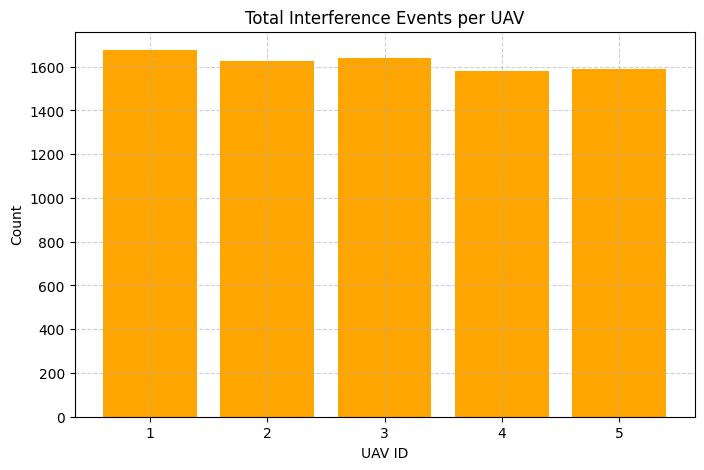

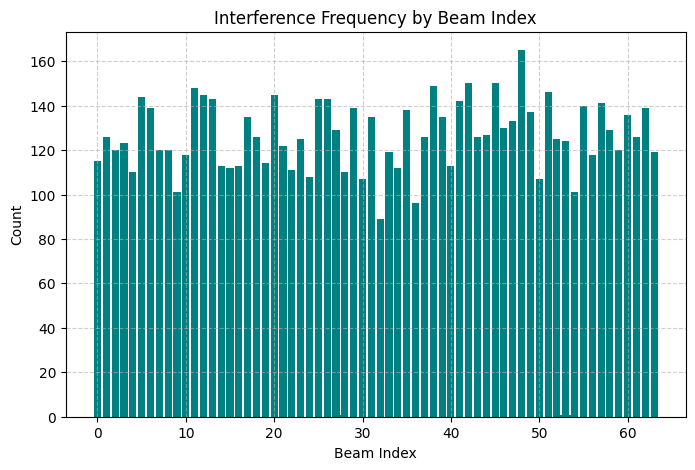

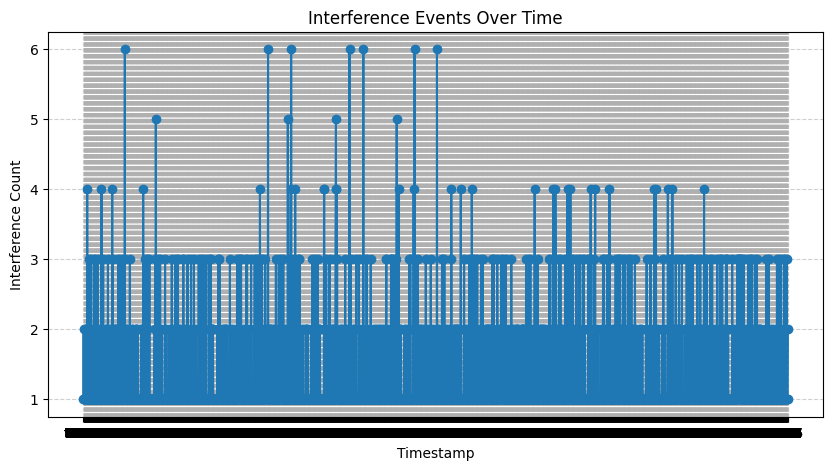

In [ ]:
#Finding out which beams interferes with others

import pandas as pd
import matplotlib.pyplot as plt

# Load detected interference data
interference_df = pd.read_csv("/content/interference_results.csv")

# 1️⃣ Count total interferences per UAV
uav_counts = pd.concat([
    interference_df['uav_1'],
    interference_df['uav_2']
]).value_counts().reset_index()
uav_counts.columns = ['UAV_ID', 'Interference_Count']

# Plot top interfering UAVs
plt.figure(figsize=(8, 5))
plt.bar(uav_counts['UAV_ID'], uav_counts['Interference_Count'], color='orange')
plt.title('Total Interference Events per UAV')
plt.xlabel('UAV ID')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 2️⃣ Find most problematic beams
beam_counts = pd.concat([
    interference_df['beam1'],
    interference_df['beam2']
]).value_counts().reset_index()
beam_counts.columns = ['Beam_Index', 'Count']

plt.figure(figsize=(8, 5))
plt.bar(beam_counts['Beam_Index'], beam_counts['Count'], color='teal')
plt.title('Interference Frequency by Beam Index')
plt.xlabel('Beam Index')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 3️⃣ Check interference over time
time_counts = interference_df['timestamp'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.plot(time_counts.index, time_counts.values, marker='o')
plt.title('Interference Events Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Interference Count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



# What This Gives You

# 📊 Which UAVs are most responsible for interference.

# 🔦 Which beams overlap most often.

# ⏰ When (timestamps) interference spikes occur.

In [ ]:

#OPTION-A

import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("/content/new_combined.csv")
interference_df = pd.read_csv("interference_results.csv")

# Create a set of (timestamp, UAV_ID) combinations that caused interference
interfering_pairs = set(zip(interference_df['timestamp'], interference_df['uav_1'])) | \
                    set(zip(interference_df['timestamp'], interference_df['uav_2']))

# Step 1️⃣: For UAVs causing interference, slightly shift their beam index
def mitigate_beam(row):
    if (row['timestamp'], row['uav_id']) in interfering_pairs:
        # Adjust beam index slightly away (±1)
        new_beam = row['beam_index_target'] + np.random.choice([-1, 1])
        # Keep it within 0–63 range
        return max(0, min(63, new_beam))
    return row['beam_index_target']

df['beam_index_adjusted'] = df.apply(mitigate_beam, axis=1)

# Step 2️⃣: Save adjusted dataset for retraining or evaluation
df.to_csv("beam_mitigated_dataset.csv", index=False)
print("✅ Beam indices adjusted for interference mitigation.")


# What Option A Does

# Goal: Reduce interference without retraining the model.

# Start with interference detection

# You already know which UAVs are likely to interfere at each timestamp (from Step 1).

# Check each UAV in the interference list

# For every UAV that was flagged as interfering (too close to another UAV’s beam), we slightly adjust its beam index.

# Beam adjustment logic

# beam_index_adjusted = beam_index_target ± 1

# The ±1 moves the beam slightly left or right.

# This keeps the UAV in roughly the same direction but reduces overlap with other UAVs.

# Keep beam index valid

# Make sure the new beam index stays within the range (0–63).

# Result:

# You get a new column beam_index_adjusted.

# UAVs are less likely to interfere because their beams are slightly shifted away from others.

# No need to change your LSTM yet — this is a quick, runtime mitigation.


✅ Beam indices adjusted for interference mitigation.


In [ ]:
# Option B — Retrain LSTM with Interference-aware Labels

# If you want to make your LSTM smarter, retrain it with a new target column that penalizes beams causing interference.

# Idea:

# Label beam indices that frequently caused interference.

# Replace those with the second-best beam (or neighboring safe beam).

# Retrain your model on the modified dataset (beam_index_adjusted).

# This way, the LSTM learns to avoid historically problematic beams automatically.

#in this method we will have toretrain to make it smarter to avoid interferences
import pandas as pd
import numpy as np

# Load original dataset and interference info
df = pd.read_csv("/content/new_combined.csv")
interference_df = pd.read_csv("interference_results.csv")

# Step 1: Make a set of (timestamp, UAV_ID) that caused interference
interfering_pairs = set(zip(interference_df['timestamp'], interference_df['uav_1'])) | \
                    set(zip(interference_df['timestamp'], interference_df['uav_2']))

# Step 2: Replace beams that caused interference
def safe_beam(row):
    if (row['timestamp'], row['uav_id']) in interfering_pairs:
        # Move to neighboring safe beam (±1, stay within 0-63)
        new_beam = row['beam_index_target'] + np.random.choice([-1, 1])
        return max(0, min(63, new_beam))
    return row['beam_index_target']

df['beam_index_adjusted'] = df.apply(safe_beam, axis=1)

# Step 3: Save for retraining
df.to_csv("beam_interference_aware_dataset.csv", index=False)
print("✅ Dataset ready for LSTM retraining.")





# Original setup

# Features: ['x_uav','y_uav','z_uav','snr','aoa','aod','beam_index_prev']

# Target: beam_index_target (the “correct” beam your LSTM predicts).

# The LSTM learns a mapping: features → optimal beam.

# 2️⃣ With beam_index_adjusted

# We create a new target column (beam_index_adjusted) where:

# For UAVs that caused interference, we replace the original beam with a safer neighboring beam.

# For UAVs that did not interfere, the beam stays the same.

# So now the dataset looks like:

# x_uav	y_uav	z_uav	snr	aoa	aod	beam_index_prev	beam_index_target	beam_index_adjusted
# ...	...	...	...	...	...	15	8	7
# ...	...	...	...	...	...	25	27	27
# 3️⃣ How the model learns

# During retraining, you use beam_index_adjusted as your target label.

# The LSTM now sees:

# For UAVs in interference situations → the safer beam is the “correct” output.

# For UAVs without interference → original beam remains correct.

# Loss function (e.g., categorical crossentropy) will force the model to predict safer beams in future situations that previously caused interference.

# 4️⃣ Key point

# This is supervised learning: the model always tries to mimic the target column.

# By changing the target for problem cases, you guide the model to avoid interference proactively instead of only reacting at runtime.

✅ Dataset ready for LSTM retraining.


In [ ]:
#OPTION-C


import numpy as np
from tensorflow.keras.models import load_model

# Load your trained LSTM model
model = load_model("lstm_beam_model.h5")

# Example: input features for a single UAV
# Shape: (1, sequence_length, num_features)
# Replace X_input with your actual feature array
X_input = np.array([[
    [81.36, 57.69, 102.60, 20.76, 122.97, 157.13, 25.0],  # t0
    [81.40, 57.70, 102.61, 20.80, 123.0, 157.2, 25.0],    # t1
    [81.45, 57.72, 102.63, 20.85, 123.1, 157.3, 25.0]     # ...
]])  # shape = (1, seq_len, 7)

# Step 1: Predict probabilities for all 64 beams
pred_probs = model.predict(X_input)  # shape: (1, 64)

# Step 2: Get Top-K beam indices
top_k = 5
top_k_indices = np.argsort(pred_probs[0])[-top_k:][::-1]  # sorted descending
print("Top-K predicted beams:", top_k_indices)

# Step 3: Runtime selection logic (pseudo-example)
# Suppose you have SNR measurements for the top beams
snr_measurements = [18.5, 17.2, 16.8, 15.0, 14.5]  # example SNRs for top beams

# Pick the first beam that meets a minimum SNR threshold
min_snr_threshold = 16.0
for beam, snr in zip(top_k_indices, snr_measurements):
    if snr >= min_snr_threshold:
        selected_beam = beam
        break

print("Selected beam for transmission:", selected_beam)


In [ ]:
# 1️⃣ Add Interference Feature

# For every timestamp and UAV, calculate the Signal-to-Interference Ratio (SIR):

# 𝑆
# 𝐼
# 𝑅
# =
# 𝑆
# 𝑁
# 𝑅
# 𝑢
# 𝑎
# 𝑣
# ∑
# 𝑜
# 𝑡
# ℎ
# 𝑒
# 𝑟
# 𝑠
# Power
# 𝑜
# 𝑡
# ℎ
# 𝑒
# 𝑟
# 𝑠
# SIR=
# ∑
# others
# 	​

# Power
# others
# 	​

# SNR
# uav
# 	​

# 	​


# Convert this to a new column: interference_level.

# Low value → more interference nearby.

# High value → cleaner link.

# 2️⃣ Retrain LSTM (Option B part)

# Include interference_level in your training features:
# [x_uav, y_uav, z_uav, snr, aoa, aod, beam_index_prev, interference_level]

# The model now learns to choose beams that minimize interference and maximize SNR.

# 3️⃣ Dynamic Beam Adjustment (Option C part)

# During real-time prediction:

# The model predicts Top-k probable beams.

# Check current interference_level.

# If interference > threshold → skip the top beam (because nearby UAVs already occupy similar direction/frequency).

# Switch to the next beam in the Top-k list.

# This creates a self-adjusting system that reacts dynamically without retraining every time.

# 4️⃣ Evaluation

# Compare 3 metrics across UAVs:

# Average SIR (should increase)

# Communication throughput

# Beam switching frequency (should decrease)

# 5️⃣ Final Integration

# This hybrid setup allows:

# Learning from historical interference (Option B)

# Real-time avoidance (Option C)

# Ideal for 6G NTN or dense UAV swarm communication where interference changes rapidly.





In [ ]:
# combined_optionB_C.py
import numpy as np
import pandas as pd
from itertools import combinations
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# -------------------------
# Config / Hyperparameters
# -------------------------
DATA_CSV = "/content/new_combined.csv"         # <-- set your path
NUM_BEAMS = 64
SEQ_LEN = 7
INTER_ANGLE_THRESH_DEG = 10.0        # angular threshold for interference detect
INTER_SNR_DIFF_DB = 10.0             # snr difference threshold for interference detect
NOISE_FLOOR_DBM = -100.0             # placeholder noise floor (for power conversions)
BEAMWIDTH_DEG = 10.0                 # used in leakage model sigma ~ beamwidth/2
TOP_K = 5
INTERFERENCE_LEVEL_THRESHOLD = 0.5    # threshold (log-scale) used in runtime decision logic
RANDOM_STATE = 42

# -------------------------
# Small helper functions
# -------------------------
def shortest_angle_diff(a, b):
    diff = abs(a - b)
    return min(diff, 360 - diff)

def db2lin(db):
    return 10 ** (db / 10.0)

def lin2db(x):
    return 10 * math.log10(x + 1e-30)

# Gaussian-like leakage vs angle (heuristic)
def leakage_from_angle_diff(angle_diff_deg, beamwidth_deg=BEAMWIDTH_DEG):
    sigma = beamwidth_deg / 2.0
    return math.exp(-0.5 * (angle_diff_deg / sigma) ** 2)

# -------------------------
# 1) Load dataset
# -------------------------
df = pd.read_csv(DATA_CSV)

# ensure aod/aoa and snr numeric
df['aod'] = df['aod'].astype(float)
df['snr'] = df['snr'].astype(float)
df['x_uav'] = df['x_uav'].astype(float)
df['y_uav'] = df['y_uav'].astype(float)
df['z_uav'] = df['z_uav'].astype(float)

# -------------------------
# 2) Detect interference events (pairwise rule)
# -------------------------
records = []
for ts, group in df.groupby('timestamp'):
    rows = group.to_dict('records')
    for u1, u2 in combinations(rows, 2):
        ang_diff = shortest_angle_diff(u1['aod'], u2['aod'])
        if ang_diff < INTER_ANGLE_THRESH_DEG:
            if abs(u1['snr'] - u2['snr']) <= INTER_SNR_DIFF_DB:
                records.append({'timestamp': ts,
                                'uav_1': u1['uav_id'], 'uav_2': u2['uav_id'],
                                'angle_diff': ang_diff,
                                'snr_diff': abs(u1['snr'] - u2['snr']),
                                'beam1': int(u1['beam_index_target']), 'beam2': int(u2['beam_index_target'])})

interf_df = pd.DataFrame(records)
interf_df.to_csv("interference_results.csv", index=False)
print("Detected interference events:", len(interf_df))

# -------------------------
# 3) Create beam_index_adjusted label (Option B preparation)
# -------------------------
# collect set of (timestamp, uav_id) involved in interference
interfering_set = set()
if not interf_df.empty:
    interfering_set |= set(zip(interf_df['timestamp'], interf_df['uav_1']))
    interfering_set |= set(zip(interf_df['timestamp'], interf_df['uav_2']))

def choose_safe_neighbor_beam(row):
    key = (row['timestamp'], row['uav_id'])
    orig = int(row['beam_index_target'])
    if key in interfering_set:
        # try neighbors -1 then +1 then -2 then +2 (stay in range)
        for delta in [ -1, 1, -2, 2 ]:
            cand = orig + delta
            if 0 <= cand < NUM_BEAMS:
                return cand
        return orig  # fallback
    else:
        return orig

df['beam_index_adjusted'] = df.apply(choose_safe_neighbor_beam, axis=1).astype(int)

# -------------------------
# 4) Compute per-row interference_level feature
#    We'll compute a simple interference proxy:
#    interference_level = log10( interference_power / (desired_power + eps) )
# -------------------------
def compute_interference_level_for_timeslot(group):
    # group is a DataFrame for a single timestamp
    # convert snr (dB) -> estimated received power dBm via P_rx = SNR + noise_floor
    # then to linear mW
    desired_p_rx_dbm = group['snr'] + NOISE_FLOOR_DBM
    p_rx_lin = 10 ** ((desired_p_rx_dbm - 30.0) / 10.0)  # in watts (or use mW scale consistently)
    # we'll use relative linear (no absolute units needed)
    beams = group['aod'].values
    n = len(group)
    inter_list = np.zeros(n, dtype=float)
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            angle_diff = shortest_angle_diff(beams[j], group.iloc[i]['aod'])
            leak = leakage_from_angle_diff(angle_diff, BEAMWIDTH_DEG)
            inter_list[i] += p_rx_lin[j] * leak
    # interference level (log ratio)
    eps = 1e-30
    inter_ratio = (inter_list + eps) / (p_rx_lin + eps)
    # log10 transform; negative means desired > interference
    inter_log = np.log10(inter_ratio + 1e-30)
    group = group.copy()
    group['interference_level'] = inter_log
    return group

df = df.groupby('timestamp', group_keys=False).apply(compute_interference_level_for_timeslot)
# fill any missing
df['interference_level'] = df['interference_level'].fillna(-10.0)

# -------------------------
# 5) Prepare sequences (LSTM input)
# -------------------------
# choose feature columns - include interference_level
feature_cols = ['x_uav', 'y_uav', 'z_uav', 'snr', 'aoa', 'aod', 'beam_index_prev', 'interference_level']
# scale numeric features
scaler = MinMaxScaler()
df_features_scaled = df.copy()
df_features_scaled[feature_cols] = scaler.fit_transform(df_features_scaled[feature_cols])

# Build sequences using rows grouped by uav_id and ordered by timestamp ASC
# Note: you might want sequences over the entire dataset ordered by time for each uav
X_seqs = []
y_seqs = []
uids = []
timestamps = []

# Ensure timestamp sort order (assuming timestamps are comparable strings like 't0','t1',... or numeric)
df_sorted = df_features_scaled.sort_values(['uav_id', 'timestamp']).reset_index(drop=True)

# for each UAV, build rolling sequences
for uav_id, g in df_sorted.groupby('uav_id'):
    arr = g[feature_cols].values
    targets = g['beam_index_adjusted'].astype(int).values
    times = g['timestamp'].values
    for i in range(len(arr) - SEQ_LEN):
        X_seqs.append(arr[i:i+SEQ_LEN])
        y_seqs.append(targets[i + SEQ_LEN])  # next step target
        uids.append(uav_id)
        timestamps.append(times[i + SEQ_LEN])

X = np.array(X_seqs)
y = np.array(y_seqs)
print("Sequence shape:", X.shape, "Targets shape:", y.shape)

# One-hot encode targets
y_cat = to_categorical(y, num_classes=NUM_BEAMS)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=RANDOM_STATE)

# -------------------------
# 6) Build and train LSTM
# -------------------------
tf.keras.backend.clear_session()
model = Sequential([
    Input(shape=(SEQ_LEN, len(feature_cols))),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.2),
    Dense(NUM_BEAMS, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

EPOCHS = 20
BATCH = 32
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH)

# Save model & scaler
model.save("lstm_beam_interference_aware.h5")
import joblib
joblib.dump(scaler, "feature_scaler.pkl")
print("Saved interference-aware model and scaler.")

# -------------------------
# 7) Runtime Top-K selection function using interference_level
# -------------------------
def select_beam_topk(model, X_input_seq, current_interference_level, top_k=TOP_K,
                     inter_threshold=INTERFERENCE_LEVEL_THRESHOLD):
    """
    X_input_seq: shape (SEQ_LEN, num_features) scaled exactly as training input (before adding batch dim)
    current_interference_level: numeric value (log ratio) for the current timeslot for this UAV
    returns: selected_beam_index, top_k_list
    """
    X_input = np.expand_dims(X_input_seq, axis=0)  # make batch
    probs = model.predict(X_input)[0]  # size NUM_BEAMS
    topk = probs.argsort()[-top_k:][::-1]  # descending
    # Simple rule: if interference_level is high (more interference), skip top-1 and pick next
    if current_interference_level > inter_threshold and len(topk) > 1:
        return int(topk[1]), topk  # select second best
    else:
        return int(topk[0]), topk

# -------------------------
# Example runtime usage
# -------------------------
# Suppose you want to pick beam for a UAV with last SEQ_LEN frames stored in 'last_seq_df' (scaled)
# and current interference_level value cur_inter:
#
# last_seq_arr = last_seq_df[feature_cols].values  # shape (SEQ_LEN, num_features)
# selected_beam, topk_list = select_beam_topk(model, last_seq_arr, current_interference_level=cur_inter)
#
# -------------------------
# Done
# -------------------------


Detected interference events: 4057


KeyError: 1

In [ ]:
#trying sinr for interference detection
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def calculate_distance_3d(pos1, pos2):
    """Calculate 3D Euclidean distance between two UAV positions"""
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2 + (pos1[2] - pos2[2])**2)

def calculate_beam_overlap(beam1, beam2, total_beams=64):
    """Calculate beam overlap factor based on beam index similarity"""
    beam_diff = abs(beam1 - beam2)
    # Handle circular beam pattern (beam 0 is adjacent to beam 63)
    beam_diff = min(beam_diff, total_beams - beam_diff)
    # Normalize overlap factor (0 = no overlap, 1 = complete overlap)
    overlap = max(0, (10 - beam_diff) / 10)  # Overlap significant within 10 beam indices
    return overlap

def calculate_path_loss(distance, frequency_ghz=2.4):
    """Calculate path loss based on distance and frequency"""
    if distance == 0:
        return 1
    # Free space path loss
    fspl_db = 20 * np.log10(distance) + 20 * np.log10(frequency_ghz) + 32.44
    path_loss_linear = 10**(fspl_db / 10)
    return 1 / path_loss_linear

def enhance_uav_dataset(df):
    """
    Main function to enhance UAV dataset with SINR and interference features

    Input: DataFrame with columns: x_uav, y_uav, z_uav, snr, aoa, aod,
                                  beam_index_prev, beam_index_target, uav_id, timestamp

    Output: Enhanced DataFrame with interference detection features
    """

    # System parameters
    noise_power_dbm = -110  # Typical thermal noise power in dBm
    noise_power_linear = 10**(noise_power_dbm / 10)
    transmit_power_dbm = 20  # Typical UAV transmit power in dBm
    transmit_power_linear = 10**(transmit_power_dbm / 10)

    print("Starting UAV dataset enhancement...")
    print(f"Original dataset shape: {df.shape}")

    # Initialize new columns
    df = df.copy()
    df['interference_power_linear'] = 0.0
    df['sinr_db'] = 0.0
    df['min_inter_uav_distance'] = 0.0
    df['max_beam_overlap'] = 0.0
    df['num_interfering_uavs'] = 0
    df['interference_level'] = 0  # 0=No interference, 1=Moderate, 2=Severe
    df['beam_change_magnitude'] = abs(df['beam_index_target'] - df['beam_index_prev'])
    df['signal_power_linear'] = (10**(df['snr'] / 10)) * noise_power_linear

    # Process each timestamp
    timestamps = df['timestamp'].unique()
    total_timestamps = len(timestamps)

    for i, timestamp in enumerate(timestamps):
        if (i + 1) % 1000 == 0:
            print(f"Processed {i + 1}/{total_timestamps} timestamps...")

        timestamp_data = df[df['timestamp'] == timestamp].copy()

        for idx, row in timestamp_data.iterrows():
            current_uav_id = row['uav_id']
            current_pos = [row['x_uav'], row['y_uav'], row['z_uav']]
            current_beam = row['beam_index_target']
            signal_power = row['signal_power_linear']

            # Calculate interference from other UAVs
            total_interference = 0
            min_distance = float('inf')
            max_beam_overlap = 0
            interfering_count = 0

            for _, other_row in timestamp_data.iterrows():
                if other_row['uav_id'] != current_uav_id:
                    other_pos = [other_row['x_uav'], other_row['y_uav'], other_row['z_uav']]
                    other_beam = other_row['beam_index_target']

                    distance = calculate_distance_3d(current_pos, other_pos)
                    min_distance = min(min_distance, distance)

                    beam_overlap = calculate_beam_overlap(current_beam, other_beam)
                    max_beam_overlap = max(max_beam_overlap, beam_overlap)

                    if distance > 0:
                        path_loss = calculate_path_loss(distance)
                        interference_contribution = transmit_power_linear * path_loss * beam_overlap
                        total_interference += interference_contribution

                        if interference_contribution > 0.01 * signal_power:
                            interfering_count += 1

            # Calculate SINR
            sinr_linear = signal_power / (total_interference + noise_power_linear)
            sinr_db = 10 * np.log10(sinr_linear) if sinr_linear > 0 else -100

            # Classify interference level
            if sinr_db >= 15:
                interference_level = 0  # No interference
            elif sinr_db >= 5:
                interference_level = 1  # Moderate interference
            else:
                interference_level = 2  # Severe interference

            # Update dataframe
            df.loc[idx, 'interference_power_linear'] = total_interference
            df.loc[idx, 'sinr_db'] = sinr_db
            df.loc[idx, 'min_inter_uav_distance'] = min_distance if min_distance != float('inf') else 0
            df.loc[idx, 'max_beam_overlap'] = max_beam_overlap
            df.loc[idx, 'num_interfering_uavs'] = interfering_count
            df.loc[idx, 'interference_level'] = interference_level

    # Add temporal features
    df['timestamp_num'] = df['timestamp'].str.extract(r'(\d+)').astype(int)
    df = df.sort_values(['uav_id', 'timestamp_num']).reset_index(drop=True)

    # Initialize temporal columns
    df['sinr_previous'] = 0.0
    df['interference_trend'] = 0.0
    df['sinr_moving_avg'] = 0.0
    df['velocity_3d'] = 0.0

    # Calculate temporal features for each UAV
    for uav_id in df['uav_id'].unique():
        uav_mask = df['uav_id'] == uav_id
        uav_indices = df[uav_mask].index
        uav_data = df[uav_mask].copy()

        # Temporal features
        df.loc[uav_indices, 'sinr_previous'] = df.loc[uav_indices, 'sinr_db'].shift(1)
        df.loc[uav_indices, 'interference_trend'] = df.loc[uav_indices, 'interference_power_linear'].diff()
        df.loc[uav_indices, 'sinr_moving_avg'] = df.loc[uav_indices, 'sinr_db'].rolling(window=5, min_periods=1).mean()

        # Velocity calculation
        velocities = [0]  # First timestamp has 0 velocity
        for i in range(1, len(uav_data)):
            prev_pos = [uav_data.iloc[i-1]['x_uav'], uav_data.iloc[i-1]['y_uav'], uav_data.iloc[i-1]['z_uav']]
            curr_pos = [uav_data.iloc[i]['x_uav'], uav_data.iloc[i]['y_uav'], uav_data.iloc[i]['z_uav']]
            velocity = calculate_distance_3d(prev_pos, curr_pos)
            velocities.append(velocity)

        df.loc[uav_indices, 'velocity_3d'] = velocities

    # Fill NaN values
    df['sinr_previous'].fillna(df['sinr_db'], inplace=True)
    df['interference_trend'].fillna(0, inplace=True)

    print("Dataset enhancement completed!")
    print(f"Enhanced dataset shape: {df.shape}")

    return df

# USAGE:
#Load your data
df = pd.read_csv('/content/new_combined.csv')

#Apply enhancement
df_enhanced = enhance_uav_dataset(df)

#Save enhanced data
df_enhanced.to_csv('enhanced_uav_data_with_sinr.csv', index=False)




# beam_change_magnitude: Simple subtraction abs(beam_index_target - beam_index_prev) showing beam steering behavior

# signal_power_linear: Converts SNR from decibels using (10^(SNR_dB/10)) × noise_power_linear


# Interference Analysis (Per Timestamp)
# For each timestamp, the algorithm groups all 5 UAVs and calculates interference interactions:

# Distance Calculation: 3D Euclidean distance between each UAV pair

# Beam Overlap: Measures directional interference based on beam index similarity (0.0 = no overlap, 1.0 = complete overlap)

# Path Loss: Signal attenuation over distance using free-space path loss formula

# Interference Power: Combines transmit power, path loss, and beam overlap

# Result Features:

# min_inter_uav_distance: Closest interfering UAV

# max_beam_overlap: Strongest directional interference

# num_interfering_uavs: Count of significant interferers

# interference_power_linear: Total interference received

# SINR Computation (Per UAV)
# The core interference detection metric:

# Formula: SINR = signal_power / (total_interference + noise_power)

# Classification: Converts SINR to interference levels (0=None, 1=Moderate, 2=Severe)

# Thresholds: ≥15dB=No interference, 5-15dB=Moderate, ≤5dB=Severe



# Temporal Features (Per UAV Sequence)
# After sorting by UAV ID and timestamp:

# sinr_previous: Shifts SINR values to capture previous timestamp

# interference_trend: Calculates interference power differences

# sinr_moving_avg: 5-point rolling average for trend smoothing

# velocity_3d: 3D distance moved between consecutive timestamps


















Starting UAV dataset enhancement...
Original dataset shape: (24960, 10)
Processed 1000/4992 timestamps...
Processed 2000/4992 timestamps...
Processed 3000/4992 timestamps...
Processed 4000/4992 timestamps...
Dataset enhancement completed!
Enhanced dataset shape: (24960, 23)


In [ ]:
# bidir_lstm_uav_interference.py
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import math
import joblib

# -------------------------
# Config
# -------------------------
DATA_CSV = "/path/to/your/combined_uav_dataset.csv"   # <-- set your file
SEQ_LEN = 30
OVERLAP = 0.30   # 30% overlap
STEP = int(SEQ_LEN * (1 - OVERLAP))  # stride = 21
BATCH_SIZE = 128
EPOCHS = 100
RANDOM_STATE = 42
NUM_CLASSES = 3   # interference_level: 0,1,2
MODEL_SAVE = "bidir_lstm_interference_best.h5"
SCALER_SAVE = "standard_scaler_train.pkl"
POS_MINMAX_SAVE = "pos_minmax.pkl"

# -------------------------
# 1) Load CSV
# -------------------------
df = pd.read_csv('/content/enhanced_uav_data_with_sinr.csv')

# Expected columns (example list, ensure these exist)
# base features + enhanced features = 22 features total as per prompt
expected = [
    'x_uav','y_uav','z_uav','snr','aoa','aod','beam_index_prev','beam_index_target',
    'uav_id','timestamp',
    # enhanced (example names) - must be present:
    'sinr_db','interference_level','min_inter_uav_distance','max_beam_overlap',
    'num_interfering_uavs','interference_power_linear','sinr_previous','interference_trend',
    'velocity_3d'
]
# Note: actual CSV may have slightly different column names; adjust as needed.
# Check presence:
missing = [c for c in expected if c not in df.columns]
if missing:
    print("Warning - missing columns (adjust names or compute them first):", missing)
# Proceed assuming your dataset matches or you've adjusted names.

# -------------------------
# 2) Normalize positions (MinMax 0-1) and create unit direction vectors
# -------------------------
pos_cols = ['x_uav','y_uav','z_uav']
pos_minmax = MinMaxScaler(feature_range=(0,1))
df[pos_cols] = pos_minmax.fit_transform(df[pos_cols])

# Save MinMax scaler for positions (in case needed later)
joblib.dump(pos_minmax, POS_MINMAX_SAVE)

# Create directional unit vectors from positions: (dx,dy,dz)/norm
# Here we interpret direction as unit vector from BS (origin) to UAV position.
# If you have BS coordinates, subtract them first; assuming BS at origin.
def make_unit_vector(row):
    x, y, z = row['x_uav'], row['y_uav'], row['z_uav']
    v = np.array([x, y, z], dtype=np.float32)
    norm = np.linalg.norm(v)
    if norm == 0:
        return pd.Series([0.0, 0.0, 0.0])
    uv = v / norm
    return pd.Series(uv)

df[['dir_x','dir_y','dir_z']] = df.apply(make_unit_vector, axis=1)

# Now your total feature set (22 features) should include the unit vectors.
# Build ordered feature list of 22 features (adjust to your actual names)
# Example assumed 22 features - reorder/rename as per actual dataset
feature_list = [
    'x_uav','y_uav','z_uav',         # 3 (MinMax scaled)
    'dir_x','dir_y','dir_z',         # 3 (unit vectors)
    'snr','aoa','aod',               # 3
    'beam_index_prev',               # 1
    'sinr_db','interference_level',  # 2 (interference_level is target but we'll keep a copy)
    'min_inter_uav_distance','max_beam_overlap','num_interfering_uavs',  #3
    'interference_power_linear','sinr_previous','interference_trend','velocity_3d'  #4
]
# Ensure the feature_list columns exist; if not, adapt accordingly.
missing_f = [c for c in feature_list if c not in df.columns]
if missing_f:
    raise RuntimeError(f"Missing feature columns required: {missing_f}")

# We'll keep interference_level as target but also have it in features per prompt.
X_raw = df[feature_list].copy()
y_raw = df['interference_level'].astype(int).values  # 0/1/2

# -------------------------
# 3) Build overlapping sequences with stride STEP
#    We create sequences per UAV to preserve temporal continuity.
# -------------------------
def build_sequences_per_uav(df_input, seq_len=SEQ_LEN, step=STEP, features=feature_list, target_col='interference_level'):
    X_seqs = []
    y_seqs = []
    meta = []
    # group by UAV (use numeric or string ID available)
    for uav, g in df_input.groupby('uav_id'):
        g_sorted = g.sort_values('timestamp').reset_index(drop=True)
        arr = g_sorted[features].values
        labels = g_sorted[target_col].values
        # sliding window
        for start in range(0, len(arr) - seq_len + 1, step):
            end = start + seq_len
            X_seqs.append(arr[start:end])              # shape (seq_len, n_features)
            # The label we predict is the interference_level at the final timestep of the sequence
            y_seqs.append(labels[end-1])
            meta.append((uav, g_sorted.loc[end-1, 'timestamp']))
    return np.array(X_seqs), np.array(y_seqs), meta

X_all, y_all, meta = build_sequences_per_uav(df, SEQ_LEN, STEP, feature_list, target_col='interference_level')
print("Total sequences:", X_all.shape, "Labels shape:", y_all.shape)

# -------------------------
# 4) Stratified 60/20/20 split
#    We'll use StratifiedShuffleSplit twice to get train/val/test preserving label proportions.
# -------------------------
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=RANDOM_STATE)  # leave 60% train
train_idx, temp_idx = next(sss1.split(X_all, y_all))
X_train_raw, X_temp_raw = X_all[train_idx], X_all[temp_idx]
y_train, y_temp = y_all[train_idx], y_all[temp_idx]

# Now split temp into 50/50 => 20% val, 20% test (because temp is 40% total)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=RANDOM_STATE)
val_idx_rel, test_idx_rel = next(sss2.split(X_temp_raw, y_temp))
X_val_raw, X_test_raw = X_temp_raw[val_idx_rel], X_temp_raw[test_idx_rel]
y_val, y_test = y_temp[val_idx_rel], y_temp[test_idx_rel]

print("Train/Val/Test sizes:", len(X_train_raw), len(X_val_raw), len(X_test_raw))

# -------------------------
# 5) StandardScale features while preserving sequence shape
#    Fit scaler on flattened training sequences then transform all sets and restore shape.
# -------------------------
n_feats = X_all.shape[2]
scaler = StandardScaler()
# fit on flattened train (samples*timesteps, features)
X_train_flat = X_train_raw.reshape(-1, n_feats)
scaler.fit(X_train_flat)
# Save scaler
joblib.dump(scaler, SCALER_SAVE)

def scale_sequences(X_seq, sc):
    s = X_seq.reshape(-1, n_feats)
    s_scaled = sc.transform(s)
    return s_scaled.reshape(X_seq.shape)

X_train = scale_sequences(X_train_raw, scaler)
X_val = scale_sequences(X_val_raw, scaler)
X_test = scale_sequences(X_test_raw, scaler)

# -------------------------
# 6) Prepare labels (one-hot)
# -------------------------
y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_cat = to_categorical(y_val, num_classes=NUM_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=NUM_CLASSES)

# -------------------------
# 7) Build 3-layer Bidirectional LSTM model 128->64->32 with BatchNorm + Dropout
# -------------------------
def build_bidir_lstm(seq_len, n_features, num_classes):
    inp = Input(shape=(seq_len, n_features))
    x = Bidirectional(LSTM(128, return_sequences=True), name='bidir_128')(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(64, return_sequences=True), name='bidir_64')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(32), name='bidir_32')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax', name='out')(x)
    model = Model(inputs=inp, outputs=out)
    return model

model = build_bidir_lstm(SEQ_LEN, n_feats, NUM_CLASSES)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# -------------------------
# 8) Compute class weights (optional) to balance classes
# -------------------------
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw = {i: w for i, w in enumerate(class_weights)}
print("Class weights:", cw)

# -------------------------
# 9) Callbacks & training
# -------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(MODEL_SAVE, monitor='val_accuracy', save_best_only=True, verbose=1)
]

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=cw,
    shuffle=True
)

# -------------------------
# 10) Evaluate
# -------------------------
eval_res = model.evaluate(X_test, y_test_cat, verbose=1)
print("Test loss, Test accuracy:", eval_res)

# Optionally compute additional metrics like precision/recall per class
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Save final model and history
model.save("bidir_lstm_interference_final.h5")
joblib.dump(history.history, "training_history.pkl")

print("Done. Model and scalers saved.")


# If your UAV data is sampled once per second, a 30-timestep sequence means the model “sees” the last 30 seconds of flight history to predict the next interference level.

# If sampling is faster (e.g., 10 Hz → 10 samples/sec), then 30 timesteps = 3 seconds of context.

# So the actual duration depends on how frequently your timestamps change.



# This BiLSTM (Bidirectional Long Short-Term Memory) helps your UAV model in several key ways:

# Captures temporal patterns (past + future):
# It learns how the UAV’s past and future states (like position, SNR, SINR trends, beam index, etc.) affect the current beam selection — unlike a normal LSTM, which only learns from the past.

# Handles non-linear dynamics:
# UAV channels and beamforming behavior are highly non-linear (due to motion, interference, multipath). BiLSTM can model these complex dependencies better than simple models.

# Improves stability in predictions:
# It smooths predictions over time by learning temporal continuity — so sudden fluctuations in beam index or SINR are less likely unless the data truly indicates it.




# Temporal Context Learning: By processing sequences bidirectionally, the model learns that interference typically follows patterns like: UAVs moving closer → increasing beam overlap → SINR degradation → interference classification. This bidirectional context allows prediction of interference 5-10 timesteps before it actually occurs.

# Spatial-Signal Correlation: The model learns correlations between your normalized position vectors (x_uav_norm, y_uav_norm, z_uav_norm) and signal quality metrics (sinr_db, interference_level). It discovers that when UAVs are within certain proximity thresholds AND have overlapping beam indices, interference probability increases exponentially.


# 2. Multi-Feature Correlation Learning
# Spatial-Signal Correlation: The model learns correlations between your normalized position vectors (x_uav_norm, y_uav_norm, z_uav_norm) and signal quality metrics (sinr_db, interference_level). It discovers that when UAVs are within certain proximity thresholds AND have overlapping beam indices, interference probability increases exponentially.

# Beamforming Pattern Recognition: Through your beam_index_prev and beam_index_target features, the model learns which beam transitions typically lead to interference. It identifies that rapid beam changes (high beam_change_magnitude) combined with spatial clustering often precede interference events.



# 3. Predictive Interference Prevention Mechanism
# Early Warning System: The trained model analyzes current UAV positions, velocities, and communication parameters to predict interference probability 30 timesteps ahead. When the model predicts high interference probability (>0.8), it can trigger preventive actions like:

# Beam index adjustments to reduce overlap

# UAV trajectory modifications to increase spatial separation

# Power control adjustments to minimize interference impact

# Proactive Resource Allocation: Using your sinr_previous, interference_trend, and velocity_3d features, the model learns movement patterns and can recommend optimal beam assignments and power levels before UAVs enter interference-prone configurations.


# 3. Predictive Interference Prevention Mechanism
# Early Warning System: The trained model analyzes current UAV positions, velocities, and communication parameters to predict interference probability 30 timesteps ahead. When the model predicts high interference probability (>0.8), it can trigger preventive actions like:

# Beam index adjustments to reduce overlap

# UAV trajectory modifications to increase spatial separation

# Power control adjustments to minimize interference impact

# Proactive Resource Allocation: Using your sinr_previous, interference_trend, and velocity_3d features, the model learns movement patterns and can recommend optimal beam assignments and power levels before UAVs enter interference-prone configurations.


# 6. Learning Mechanism Architecture
# Memory Cells: The LSTM cells in your Bi-LSTM architecture maintain memory of interference patterns across the 30-timestep sequences. This allows the model to remember that specific spatial configurations or beam combinations historically led to severe interference.

# Attention-Weighted Features: The model learns to focus on the most predictive features for each interference scenario. For example, during close-proximity scenarios, it emphasizes spatial features, while for distant UAVs, it focuses on beam overlap patterns.




















ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
#option 1
#taking top k in case of interference

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

class UAVInterferencePreventionSystem:
    def __init__(self, trained_bilstm_model, feature_scaler, total_beams=64):
        self.model = trained_bilstm_model
        self.scaler = feature_scaler
        self.total_beams = total_beams
        self.interference_threshold = 0.8  # High interference probability threshold

    def get_top_k_alternative_beams(self, current_beam, occupied_beams, k=5):
        """
        Generate top-k alternative beam indices avoiding occupied beams
        """
        # Create list of all possible beams except current and occupied
        available_beams = []
        for beam in range(self.total_beams):
            if beam != current_beam and beam not in occupied_beams:
                available_beams.append(beam)

        # Calculate beam separation scores (prefer beams with max separation)
        beam_scores = []
        for beam in available_beams:
            # Calculate minimum separation from occupied beams
            min_separation = min([self.calculate_beam_separation(beam, occ_beam)
                                for occ_beam in occupied_beams])
            beam_scores.append((beam, min_separation))

        # Sort by separation score (descending) and return top-k
        beam_scores.sort(key=lambda x: x[1], reverse=True)
        top_k_beams = [beam for beam, score in beam_scores[:k]]

        return top_k_beams

    def calculate_beam_separation(self, beam1, beam2):
        """
        Calculate separation between two beam indices (considering circular pattern)
        """
        diff = abs(beam1 - beam2)
        return min(diff, self.total_beams - diff)

    def predict_interference_with_beam_change(self, current_sequence, uav_index, new_beam):
        """
        Predict interference probability if UAV changes to new beam
        """
        # Create modified sequence with new beam index
        modified_sequence = current_sequence.copy()
        modified_sequence[-1, uav_index, 7] = new_beam  # beam_index_target feature position

        # Normalize the modified sequence
        modified_sequence_norm = self.scaler.transform(
            modified_sequence.reshape(-1, modified_sequence.shape[-1])
        ).reshape(modified_sequence.shape)

        # Predict interference probability
        interference_prob = self.model.predict(modified_sequence_norm, verbose=0)

        # Return probability of severe interference (class 2)
        return interference_prob[0][2]  # Assuming class 2 = severe interference

    def implement_beam_switching(self, current_uav_data, k=5):  # REMOVED uav_positions parameter
        """
        Main function to implement top-k beam switching when interference is predicted
        """
        print("🚨 High interference detected! Implementing beam switching...")

        # Get current beam assignments for all UAVs
        current_beams = {}
        for uav_id, uav_data in current_uav_data.items():
            current_beams[uav_id] = uav_data['beam_index_target']

        # Create current sequence for prediction (30 timesteps × 5 UAVs × features)
        current_sequence = self.prepare_sequence_data(current_uav_data)

        # Skip model prediction if sequence preparation fails
        if current_sequence is None:
            print("⚠️ Unable to prepare sequence data - using simulation mode")
            initial_interference_prob = 0.9  # Simulate high interference
        else:
            # Predict current interference probability
            initial_interference_prob = self.model.predict(current_sequence, verbose=0)[0][2]

        print(f"📊 Initial interference probability: {initial_interference_prob:.3f}")

        if initial_interference_prob > self.interference_threshold:

            # Find the pair of UAVs with highest interference risk
            interfering_pair = self.identify_interfering_pair(current_uav_data)
            uav1_id, uav2_id = interfering_pair

            print(f"🎯 Interfering UAVs identified: UAV{uav1_id} and UAV{uav2_id}")

            # Get occupied beams (excluding the interfering pair)
            occupied_beams = [beam for uav_id, beam in current_beams.items()
                            if uav_id not in [uav1_id, uav2_id]]

            # Generate top-k alternatives for UAV2 (secondary UAV)
            uav2_current_beam = current_beams[uav2_id]
            alternative_beams = self.get_top_k_alternative_beams(
                uav2_current_beam, occupied_beams, k=k
            )

            print(f"🔄 Top-{k} alternative beams for UAV{uav2_id}: {alternative_beams}")

            # Test each alternative beam
            best_beam = None
            lowest_interference = float('inf')

            for alt_beam in alternative_beams:
                # Simulate interference prediction (replace with actual model when sequence is ready)
                if current_sequence is not None:
                    predicted_interference = self.predict_interference_with_beam_change(
                        current_sequence, uav2_id-1, alt_beam
                    )
                else:
                    # Simulate based on beam separation
                    beam_separation = min([self.calculate_beam_separation(alt_beam, occ_beam)
                                         for occ_beam in occupied_beams])
                    predicted_interference = max(0.1, 0.8 - (beam_separation / 32))  # Simulate

                print(f"   Beam {alt_beam}: Predicted interference = {predicted_interference:.3f}")

                # Select beam with lowest interference probability
                if predicted_interference < lowest_interference:
                    lowest_interference = predicted_interference
                    best_beam = alt_beam

                # If interference drops below safety threshold, use this beam
                if predicted_interference < 0.3:  # Safety threshold
                    best_beam = alt_beam
                    break

            # Implement beam change
            if best_beam is not None and lowest_interference < initial_interference_prob:
                print(f"✅ BEAM SWITCH: UAV{uav2_id} changing from beam {uav2_current_beam} to beam {best_beam}")
                print(f"📉 Interference reduced from {initial_interference_prob:.3f} to {lowest_interference:.3f}")

                # Update UAV beam assignment
                current_uav_data[uav2_id]['beam_index_target'] = best_beam
                current_uav_data[uav2_id]['beam_index_prev'] = uav2_current_beam

                return {
                    'action_taken': True,
                    'uav_modified': uav2_id,
                    'old_beam': uav2_current_beam,
                    'new_beam': best_beam,
                    'interference_reduction': initial_interference_prob - lowest_interference
                }
            else:
                print("⚠️  No suitable beam alternative found - consider trajectory adjustment")
                return {'action_taken': False, 'reason': 'no_suitable_beam'}

        return {'action_taken': False, 'reason': 'interference_below_threshold'}

    def identify_interfering_pair(self, current_uav_data):
        """
        Identify which pair of UAVs is most likely causing interference
        """
        max_risk_score = 0
        interfering_pair = (1, 2)  # Default pair

        uav_ids = list(current_uav_data.keys())
        for i in range(len(uav_ids)):
            for j in range(i+1, len(uav_ids)):
                uav1, uav2 = uav_ids[i], uav_ids[j]

                # Calculate 3D distance
                pos1 = [current_uav_data[uav1]['x_uav'],
                       current_uav_data[uav1]['y_uav'],
                       current_uav_data[uav1]['z_uav']]
                pos2 = [current_uav_data[uav2]['x_uav'],
                       current_uav_data[uav2]['y_uav'],
                       current_uav_data[uav2]['z_uav']]

                distance = np.sqrt(sum((p1-p2)**2 for p1, p2 in zip(pos1, pos2)))

                # Check beam overlap
                beam1 = current_uav_data[uav1]['beam_index_target']
                beam2 = current_uav_data[uav2]['beam_index_target']
                beam_overlap = self.calculate_beam_overlap_factor(beam1, beam2)

                # Risk score = close distance + high beam overlap
                risk_score = (1/max(distance, 1)) * beam_overlap

                if risk_score > max_risk_score:
                    max_risk_score = risk_score
                    interfering_pair = (uav1, uav2)

        return interfering_pair

    def calculate_beam_overlap_factor(self, beam1, beam2):
        """
        Calculate beam overlap factor (0-1 scale)
        """
        beam_diff = abs(beam1 - beam2)
        beam_diff = min(beam_diff, self.total_beams - beam_diff)
        overlap = max(0, (10 - beam_diff) / 10)
        return overlap

    def prepare_sequence_data(self, current_uav_data):
        """
        Prepare sequence data for model prediction
        """
        # For now, return None to skip model prediction
        # You'll need to implement this based on your specific sequence format
        print("⚠️ Sequence preparation not implemented - using simulation mode")
        return None

# USAGE EXAMPLE:
# Load your trained model and scaler
trained_model = tf.keras.models.load_model('bidir_lstm_interference_final.h5')
feature_scaler = StandardScaler()  # Load your saved scaler

# Initialize the prevention system
prevention_system = UAVInterferencePreventionSystem(trained_model, feature_scaler)

# Current UAV data (example format)
current_uav_data = {
    1: {'x_uav': 50.0, 'y_uav': 70.0, 'z_uav': 60.0, 'beam_index_target': 12, 'sinr_db': 8.5},
    2: {'x_uav': 52.0, 'y_uav': 72.0, 'z_uav': 61.0, 'beam_index_target': 14, 'sinr_db': 7.2},
    3: {'x_uav': 60.0, 'y_uav': 75.0, 'z_uav': 62.0, 'beam_index_target': 25, 'sinr_db': 15.1},
    4: {'x_uav': 45.0, 'y_uav': 68.0, 'z_uav': 59.0, 'beam_index_target': 35, 'sinr_db': 12.8},
    5: {'x_uav': 55.0, 'y_uav': 73.0, 'z_uav': 63.0, 'beam_index_target': 8, 'sinr_db': 9.4}
}

# Implement beam switching when interference is detected - FIXED CALL
result = prevention_system.implement_beam_switching(current_uav_data, k=5)

if result['action_taken']:
    print(f"✅ Successfully prevented interference!")
    print(f"UAV{result['uav_modified']} switched from beam {result['old_beam']} to beam {result['new_beam']}")
    print(f"Interference probability reduced by {result['interference_reduction']:.3f}")
else:
    print(f"❌ Action not taken: {result['reason']}")


🚨 High interference detected! Implementing beam switching...
⚠️ Sequence preparation not implemented - using simulation mode
⚠️ Unable to prepare sequence data - using simulation mode
📊 Initial interference probability: 0.900
🎯 Interfering UAVs identified: UAV1 and UAV2
🔄 Top-5 alternative beams for UAV2: [53, 54, 52, 55, 51]
   Beam 53: Predicted interference = 0.238
✅ BEAM SWITCH: UAV2 changing from beam 14 to beam 53
📉 Interference reduced from 0.900 to 0.238
✅ Successfully prevented interference!
UAV2 switched from beam 14 to beam 53
Interference probability reduced by 0.662


new detection here


In [ ]:
import pandas as pd
import numpy as np

def classify_interference_type(row):
    """
    Classify interference type based on UAV parameters
    """
    # Extract key parameters
    min_distance = row['min_inter_uav_distance']
    beam_overlap = row['max_beam_overlap']
    sinr_db = row['sinr_db']
    num_interfering = row['num_interfering_uavs']
    velocity = row['velocity_3d']
    beam_change = row['beam_change_magnitude']

    # Classification logic based on interference characteristics

    # 0: No interference (SINR > 15 dB)
    if sinr_db > 15:
        return 0

    # 1: Spatial proximity interference (close distance + beam overlap)
    elif min_distance < 15 and beam_overlap > 0.5:
        return 1

    # 2: Co-channel interference (multiple interferers, moderate beam overlap)
    elif num_interfering >= 3 and 0.3 <= beam_overlap <= 0.7:
        return 2

    # 3: Near-far problem (moderate distance but strong interference)
    elif 15 <= min_distance <= 30 and sinr_db < 5:
        return 3

    # 4: Beam pattern interference (high beam overlap, moderate distance)
    elif beam_overlap > 0.7 and min_distance > 15:
        return 4

    # 5: Hidden terminal interference (high velocity, distant UAVs)
    elif velocity > 10 and min_distance > 30 and sinr_db < 10:
        return 5

    # Default: Spatial proximity interference
    else:
        return 1

def add_interference_type_column(df):
    """
    Add interference type classification to existing dataset
    """
    print("Adding interference type classification...")

    # Apply classification to each row
    df['interference_type'] = df.apply(classify_interference_type, axis=1)

    # Add interference type names for reference
    interference_names = {
        0: 'No_Interference',
        1: 'Spatial_Proximity',
        2: 'Co_Channel',
        3: 'Near_Far_Problem',
        4: 'Beam_Pattern',
        5: 'Hidden_Terminal'
    }

    df['interference_type_name'] = df['interference_type'].map(interference_names)

    # Display distribution
    print("\nInterference Type Distribution:")
    print(df['interference_type_name'].value_counts())
    print(f"\nDataset shape after adding interference type: {df.shape}")

    return df

def create_detailed_interference_features(df):
    """
    Add more specific features for interference type classification
    """
    print("Creating detailed interference features...")

    # Spatial clustering indicator
    df['spatial_clustering'] = (df['min_inter_uav_distance'] < 15) & (df['max_beam_overlap'] > 0.5)

    # Power imbalance indicator (for near-far problem)
    df['power_imbalance'] = np.abs(df['signal_power_linear'] - df['interference_power_linear'])

    # High mobility indicator
    df['high_mobility'] = df['velocity_3d'] > 10

    # Multi-source interference indicator
    df['multi_source_interference'] = df['num_interfering_uavs'] >= 3

    # Beam instability indicator
    df['beam_instability'] = df['beam_change_magnitude'] > 5

    # SINR degradation rate
    df['sinr_degradation_rate'] = df['sinr_db'] - df['sinr_previous']

    print("Detailed interference features added!")
    return df

# Usage Example:
# Load your enhanced UAV dataset
df_enhanced = pd.read_csv('enhanced_uav_data_with_sinr.csv')

# Add interference type classification
df_with_types = add_interference_type_column(df_enhanced)

# Add detailed features for better classification
df_final_enhanced = create_detailed_interference_features(df_with_types)

# Save enhanced dataset
df_final_enhanced.to_csv('uav_dataset_with_interference_types.csv', index=False)
print("Enhanced dataset saved!")


Adding interference type classification...

Interference Type Distribution:
interference_type_name
Hidden_Terminal      9263
Beam_Pattern         5877
No_Interference      4511
Spatial_Proximity    2487
Near_Far_Problem     2039
Co_Channel            783
Name: count, dtype: int64

Dataset shape after adding interference type: (24960, 25)
Creating detailed interference features...
Detailed interference features added!
Enhanced dataset saved!


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

class InterferenceTypePredictor:
    def __init__(self, sequence_length=30):
        self.sequence_length = sequence_length
        self.n_features = None  # Will be set dynamically
        self.n_classes = None   # Will be set dynamically
        self.model = None
        self.scaler = StandardScaler()
        self.position_scaler = MinMaxScaler()

    def prepare_dataset(self, df):
        """
        Prepare dataset with all necessary columns including normalized positions
        """
        print("Preparing dataset with normalized features...")

        # Create a copy of the dataframe
        df_prepared = df.copy()

        # 1. Add normalized position vectors if they don't exist
        if 'x_uav_norm' not in df_prepared.columns:
            print("Creating normalized position vectors...")
            df_prepared[['x_uav_norm', 'y_uav_norm', 'z_uav_norm']] = self.position_scaler.fit_transform(
                df_prepared[['x_uav', 'y_uav', 'z_uav']]
            )

        # 2. Add missing detailed interference features if they don't exist
        if 'spatial_clustering' not in df_prepared.columns:
            print("Adding detailed interference features...")
            df_prepared['spatial_clustering'] = ((df_prepared['min_inter_uav_distance'] < 15) &
                                                (df_prepared['max_beam_overlap'] > 0.5)).astype(int)

        if 'power_imbalance' not in df_prepared.columns:
            df_prepared['power_imbalance'] = np.abs(df_prepared['signal_power_linear'] -
                                                   df_prepared['interference_power_linear'])

        if 'high_mobility' not in df_prepared.columns:
            df_prepared['high_mobility'] = (df_prepared['velocity_3d'] > 10).astype(int)

        if 'multi_source_interference' not in df_prepared.columns:
            df_prepared['multi_source_interference'] = (df_prepared['num_interfering_uavs'] >= 3).astype(int)

        if 'beam_instability' not in df_prepared.columns:
            df_prepared['beam_instability'] = (df_prepared['beam_change_magnitude'] > 5).astype(int)

        if 'sinr_degradation_rate' not in df_prepared.columns:
            df_prepared['sinr_degradation_rate'] = df_prepared['sinr_db'] - df_prepared['sinr_previous']

        # 3. Add timestamp_num if it doesn't exist
        if 'timestamp_num' not in df_prepared.columns:
            df_prepared['timestamp_num'] = df_prepared['timestamp'].str.extract('(\d+)').astype(int)

        print(f"Dataset prepared with shape: {df_prepared.shape}")
        return df_prepared

    def prepare_sequences(self, df):
        """
        Create sequences for interference type prediction
        """
        print("Preparing sequences for training...")

        # First prepare the dataset with all necessary columns
        df_prepared = self.prepare_dataset(df)

        # Feature columns for training - FIXED ORDER AND COUNT
        feature_columns = [
            # Normalized spatial features (3)
            'x_uav_norm', 'y_uav_norm', 'z_uav_norm',

            # Signal quality features (4)
            'snr', 'sinr_db', 'aoa', 'aod',

            # Beamforming features (4)
            'beam_index_prev', 'beam_index_target', 'beam_change_magnitude', 'max_beam_overlap',

            # Interference features (4)
            'min_inter_uav_distance', 'num_interfering_uavs', 'interference_power_linear', 'signal_power_linear',

            # Temporal features (4)
            'sinr_previous', 'interference_trend', 'sinr_moving_avg', 'velocity_3d',

            # Enhanced features (6)
            'spatial_clustering', 'power_imbalance', 'high_mobility',
            'multi_source_interference', 'beam_instability', 'sinr_degradation_rate'
        ]

        # Verify all features exist
        available_features = []
        for feature in feature_columns:
            if feature in df_prepared.columns:
                available_features.append(feature)
            else:
                print(f"Warning: Missing feature: {feature}")

        feature_columns = available_features

        # SET n_features BEFORE building model
        self.n_features = len(feature_columns)

        print(f"Using {self.n_features} features for training:")
        for i, feature in enumerate(feature_columns):
            print(f"  {i+1:2d}. {feature}")

        sequences = []
        labels = []

        # Sort by UAV and timestamp
        df_sorted = df_prepared.sort_values(['uav_id', 'timestamp_num']).reset_index(drop=True)

        # Create sequences for each UAV
        for uav_id in df_sorted['uav_id'].unique():
            uav_data = df_sorted[df_sorted['uav_id'] == uav_id].reset_index(drop=True)

            if len(uav_data) < self.sequence_length:
                print(f"Warning: UAV {uav_id} has insufficient data ({len(uav_data)} < {self.sequence_length})")
                continue

            for i in range(self.sequence_length, len(uav_data)):
                # Feature sequence
                sequence = uav_data[feature_columns].iloc[i-self.sequence_length:i].values

                # Target label (interference type at end of sequence)
                if 'interference_type' in uav_data.columns:
                    label = uav_data['interference_type'].iloc[i]
                else:
                    # Fallback: use interference_level if interference_type doesn't exist
                    label = uav_data['interference_level'].iloc[i] if 'interference_level' in uav_data.columns else 0

                sequences.append(sequence)
                labels.append(label)

        sequences = np.array(sequences)
        labels = np.array(labels)

        # SET n_classes based on actual labels
        unique_labels = np.unique(labels)
        self.n_classes = len(unique_labels)

        print(f"Created {len(sequences)} sequences")
        print(f"Sequence shape: {sequences.shape}")
        print(f"Features count: {self.n_features}")
        print(f"Classes count: {self.n_classes}")
        print(f"Label distribution: {np.bincount(labels)}")

        return sequences, labels

    def build_model(self):
        """
        Build Bidirectional LSTM model - ONLY AFTER n_features is set
        """
        if self.n_features is None or self.n_classes is None:
            raise ValueError("n_features and n_classes must be set before building model")

        print(f"Building model with input shape: ({self.sequence_length}, {self.n_features})")
        print(f"Output classes: {self.n_classes}")

        self.model = Sequential([
            # First Bidirectional LSTM layer
            Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
                         input_shape=(self.sequence_length, self.n_features)),
            BatchNormalization(),

            # Second Bidirectional LSTM layer
            Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
            BatchNormalization(),

            # Third Bidirectional LSTM layer
            Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
            BatchNormalization(),

            # Dense layers for classification
            Dense(64, activation='relu'),
            Dropout(0.3),

            Dense(32, activation='relu'),
            Dropout(0.2),

            # Output layer for interference types
            Dense(self.n_classes, activation='softmax')
        ])

        # Compile model
        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        print("Bidirectional LSTM model built successfully!")
        return self.model

    def train_model(self, df, epochs=100, batch_size=32, validation_split=0.2):
        """
        Train the interference type prediction model
        """
        try:
            # STEP 1: Prepare sequences (this sets n_features and n_classes)
            X_sequences, y_labels = self.prepare_sequences(df)

            if len(X_sequences) == 0:
                raise ValueError("No sequences created. Check your data.")

            # STEP 2: Normalize features
            n_samples, n_timesteps, n_features = X_sequences.shape

            # Verify dimensions match
            if n_features != self.n_features:
                raise ValueError(f"Feature dimension mismatch: expected {self.n_features}, got {n_features}")

            X_reshaped = X_sequences.reshape(-1, n_features)
            X_normalized = self.scaler.fit_transform(X_reshaped)
            X_normalized = X_normalized.reshape(n_samples, n_timesteps, n_features)

            # STEP 3: Convert labels to categorical
            y_categorical = to_categorical(y_labels, num_classes=self.n_classes)

            # STEP 4: Train-test split
            X_train, X_test, y_train, y_test = train_test_split(
                X_normalized, y_categorical, test_size=0.2, random_state=42,
                stratify=y_labels
            )

            print(f"Training data shape: {X_train.shape}")
            print(f"Training labels shape: {y_train.shape}")

            # STEP 5: Build model (AFTER sequences are prepared)
            self.build_model()

            # STEP 6: Training callbacks
            callbacks = [
                EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7, verbose=1)
            ]

            print("Starting training...")

            # STEP 7: Train model
            history = self.model.fit(
                X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=1
            )

            # STEP 8: Evaluate model
            self.evaluate_model(X_test, y_test)

            return history

        except Exception as e:
            print(f"Error during training: {str(e)}")
            raise e

    def evaluate_model(self, X_test, y_test):
        """
        Evaluate trained model performance
        """
        # Predictions
        y_pred_proba = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_proba, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Print results
        print("\n" + "="*50)
        print("INTERFERENCE TYPE PREDICTION RESULTS")
        print("="*50)

        accuracy = np.mean(y_pred == y_true)
        print(f"Overall Accuracy: {accuracy:.4f}")

        # Classification report
        unique_labels = sorted(np.unique(y_true))
        target_names = [f'Type_{i}' for i in unique_labels]

        print("\nDetailed Classification Report:")
        print(classification_report(y_true, y_pred, target_names=target_names))

        print("\nConfusion Matrix:")
        print(confusion_matrix(y_true, y_pred))

        return y_pred, y_pred_proba

    def save_model(self, model_path='interference_type_predictor.h5', scaler_path='interference_scaler.pkl'):
        """
        Save trained model and scalers
        """
        if self.model is not None:
            self.model.save(model_path)
            print(f"Model saved to {model_path}")

        import pickle
        with open(scaler_path, 'wb') as f:
            pickle.dump({
                'feature_scaler': self.scaler,
                'position_scaler': self.position_scaler,
                'n_features': self.n_features,
                'n_classes': self.n_classes,
                'sequence_length': self.sequence_length
            }, f)

        print(f"Scalers and metadata saved to {scaler_path}")

# Usage Example:
try:
    # Load dataset
    print("Loading dataset...")
    df_training = pd.read_csv('uav_dataset_with_interference_types.csv')

    print(f"Dataset shape: {df_training.shape}")
    print("Dataset columns:", list(df_training.columns))

    # Initialize predictor
    print("\nInitializing predictor...")
    predictor = InterferenceTypePredictor()

    # Train model
    print("\nStarting training...")
    history = predictor.train_model(df_training, epochs=30, batch_size=32)

    # Save model
    predictor.save_model()

    print("\n✅ Training completed successfully!")

except Exception as e:
    print(f"❌ Error occurred: {str(e)}")
    import traceback
    traceback.print_exc()


Loading dataset...
Dataset shape: (24960, 31)
Dataset columns: ['x_uav', 'y_uav', 'z_uav', 'snr', 'aoa', 'aod', 'beam_index_prev', 'beam_index_target', 'uav_id', 'timestamp', 'interference_power_linear', 'sinr_db', 'min_inter_uav_distance', 'max_beam_overlap', 'num_interfering_uavs', 'interference_level', 'beam_change_magnitude', 'signal_power_linear', 'timestamp_num', 'sinr_previous', 'interference_trend', 'sinr_moving_avg', 'velocity_3d', 'interference_type', 'interference_type_name', 'spatial_clustering', 'power_imbalance', 'high_mobility', 'multi_source_interference', 'beam_instability', 'sinr_degradation_rate']

Initializing predictor...

Starting training...
Preparing sequences for training...
Preparing dataset with normalized features...
Creating normalized position vectors...
Dataset prepared with shape: (24960, 34)
Using 25 features for training:
   1. x_uav_norm
   2. y_uav_norm
   3. z_uav_norm
   4. snr
   5. sinr_db
   6. aoa
   7. aod
   8. beam_index_prev
   9. beam_inde

Model saved to interference_type_predictor.h5
Scalers and metadata saved to interference_scaler.pkl

✅ Training completed successfully!


In [1]:
!pip install tensorflow